In [1]:
!pip install -q medmnist
!pip install -q xgboost scikit-learn matplotlib seaborn opencv-python albumentations scikit-image mahotas scipy imbalanced-learn umap-learn tensorflow pillow tqdm
!mkdir class_task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.0 MB/s eta 0:00:00


In [2]:
import medmnist
from medmnist import INFO
from medmnist import PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

In [ ]:
# data will go to ~/.medmnist by default
train_dataset = PathMNIST(split='train', download=True, size=224)
val_dataset = PathMNIST(split='val', download=True, size=224)
test_dataset = PathMNIST(split='test', download=True, size=224)

!cp /root/.medmnist/pathmnist_224.npz /content/class_task/

100%|██████████| 12.6G/12.6G [51:02<00:00, 4.12MB/s]


In [3]:
# I will use my Google Drive as a persistent cache
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import shutil

shutil.copy('/root/.medmnist/pathmnist_224.npz', '/content/drive/MyDrive/aml_project/pathmnist_224.npz')

'/content/drive/MyDrive/aml_project/pathmnist_224.npz'

In [4]:
# Import the dataset from the drive
!mkdir -p /root/.medmnist
!cp /content/drive/MyDrive/aml_project/pathmnist_224.npz /root/.medmnist/pathmnist_224.npz
# !cp /root/.medmnist/pathmnist_224.npz /content/class_task/

In [ ]:
train_dataset = PathMNIST(split='train', download=False, size=224)
val_dataset = PathMNIST(split='val', download=False, size=224)
test_dataset = PathMNIST(split='test', download=False, size=224)

In [8]:
from collections import Counter

pathmnist_classes = {
    0: "Background",
    1: "Normal colon mucosa",
    2: "Colon mucosa",
    3: "Colon submucosa",
    4: "Lymphoid tissue",
    5: "Debris",
    6: "Cancer-associated stroma",
    7: "Tumor epithelium",
    8: "Mucus"
}

# Class distribution
def analyze_class_distribution(dataset, split_name):
    labels = dataset.labels.flatten()
    counts = Counter(labels)

    print(f"\n Class distribution in {split_name} set:")
    for cls_idx in range(9):
        class_name = pathmnist_classes[cls_idx]
        print(f"  {class_name:30s}: {counts[cls_idx]} samples")

    class_names = [pathmnist_classes[i] for i in range(9)]
    class_counts = [counts[i] for i in range(9)]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, class_counts, color='steelblue')
    plt.title(f"{split_name.capitalize()} Set - Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

analyze_class_distribution(train_dataset, "train")
analyze_class_distribution(val_dataset, "validation")
analyze_class_distribution(test_dataset, "test")


NameError: name 'train_dataset' is not defined

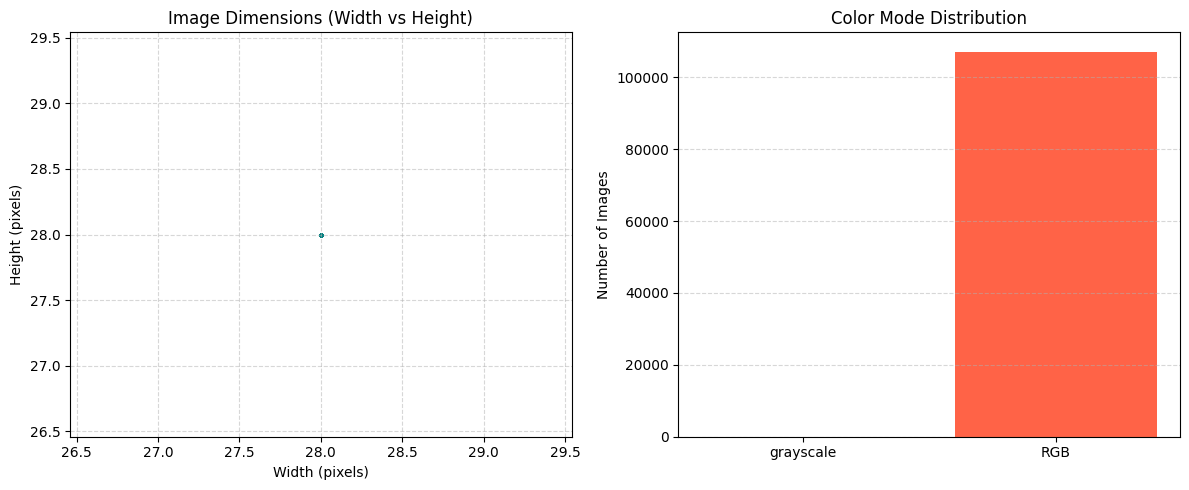

In [5]:
all_images = np.concatenate([train_dataset.imgs, val_dataset.imgs, test_dataset.imgs], axis=0)  # shape: (N, H, W, C)

heights = [img.shape[0] for img in all_images]
widths  = [img.shape[1] for img in all_images]

color_modes = {"grayscale": 0, "RGB": 0}
for img in all_images:
    if img.shape[-1] == 1:
        color_modes["grayscale"] += 1
    elif img.shape[-1] == 3:
        color_modes["RGB"] += 1

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Image Dimensions
axes[0].scatter(widths, heights, alpha=0.3, color="teal", s=2)
axes[0].set_title("Image Dimensions (Width vs Height)")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Height (pixels)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Color Mode Distribution
axes[1].bar(color_modes.keys(), color_modes.values(), color=['gray', 'tomato'])
axes[1].set_title("Color Mode Distribution")
axes[1].set_ylabel("Number of Images")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import albumentations as A
import cv2
import random
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.filters import sobel, gabor
from skimage.color import rgb2gray
import mahotas
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier


TARGET_SIZE = 6000
TRAINING_TARGET_SIZE = 4000
AUGMENTATION_THRESHOLD = 0.5
MAX_AUGMENTATION_FACTOR = 6
TRAIN_SIZE = 0.6
VAL_SIZE = 0.20
TEST_SIZE = 0.20
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)